LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [1]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *
import mosek.fusion.pythonic       # Requires MOSEK >= 10.2

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [2]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
matplotlib: 3.7.2


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [3]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [4]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [5]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
df_prices, _ = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

In [6]:
def RiskBudgeting(N, G, b, z, a):
    
    with Model('Risk budgeting') as M:
        # Settings
        M.setLogHandler(sys.stdout)
        
        # Portfolio weights
        x = M.variable("x", N, Domain.unbounded())
      
        # Auxiliary variables
        t = M.variable("t", N, Domain.unbounded())
        s = M.variable("s", 1, Domain.unbounded())
    
        # Objective function: 1/2 * x'Sx - a * b'log(z*x) becomes s - a * b't
        M.objective(ObjectiveSense.Minimize, s - a * (t.T @ b))
    
        # Bound on risk term
        M.constraint(Expr.vstack(s, 1, G.T @ x), Domain.inRotatedQCone())
    
        # Bound on log term t <= log(z*x) becomes (z*x, 1, t) in K_exp
        M.constraint(Expr.hstack(Expr.mulElm(z, x), Expr.constTerm(N, 1.0), t), Domain.inPExpCone())
    
        # Create DataFrame to store the results.
        columns = ["obj", "risk", "xsum", "bsum"] + df_prices.columns.tolist()
        df_result = pd.DataFrame(columns=columns) 
    
        # Solve optimization
        M.solve()
        # Check if the solution is an optimal point
        solsta = M.getPrimalSolutionStatus()
        if (solsta != SolutionStatus.Optimal):
            # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
            raise Exception("Unexpected solution status!")
    
        # Save results
        xv = x.level()
                   
        # Check solution quality
        risk_budgets = xv * np.dot(G @ G.T, xv)
       
        # Renormalize to gross exposure = 1
        xv = xv / np.abs(xv).sum()
        
        # Compute portfolio metrics
        Gx = np.dot(G.T, xv)
        portfolio_risk = np.sqrt(np.dot(Gx, Gx))
               
        row = pd.Series([M.primalObjValue(), portfolio_risk, np.sum(z * xv), np.sum(risk_budgets)] + list(xv), index=columns)
        df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)
        row = pd.Series([None] * 4 + list(risk_budgets), index=columns)
        df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [7]:
# Number of securities
N = df_prices.shape[1]

# Get optimization parameters
_, S = compute_inputs(df_prices)

# Risk budget
b = np.ones(N) / N

# Orthant selector
z = np.ones(N)

# Global setting for sum of b
a = 1

Next we compute the matrix $G$ such that $\ECov=GG^\mathsf{T}$, this is the input of the conic form of the optimization problem. Here we use Cholesky factorization.

In [8]:
G = np.linalg.cholesky(S)  

## Call the optimizer function

In [9]:
df_result = RiskBudgeting(N, G, b, z, a)

Problem
  Name                   : Risk budgeting  
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 8               
  Affine conic cons.     : 9 (34 rows)
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 18              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0                

In [10]:
df_result

,obj,risk,xsum,bsum,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,1.042655,0.212983,1.0,1.000007,0.128198,0.134368,0.147567,0.137782,0.090373,0.114948,0.114974,0.131791
1,NaN,NaN,NaN,NaN,0.125001,0.125001,0.125001,0.125001,0.125001,0.125001,0.125001,0.125001


## Visualize the results

Plot the portfolio components.

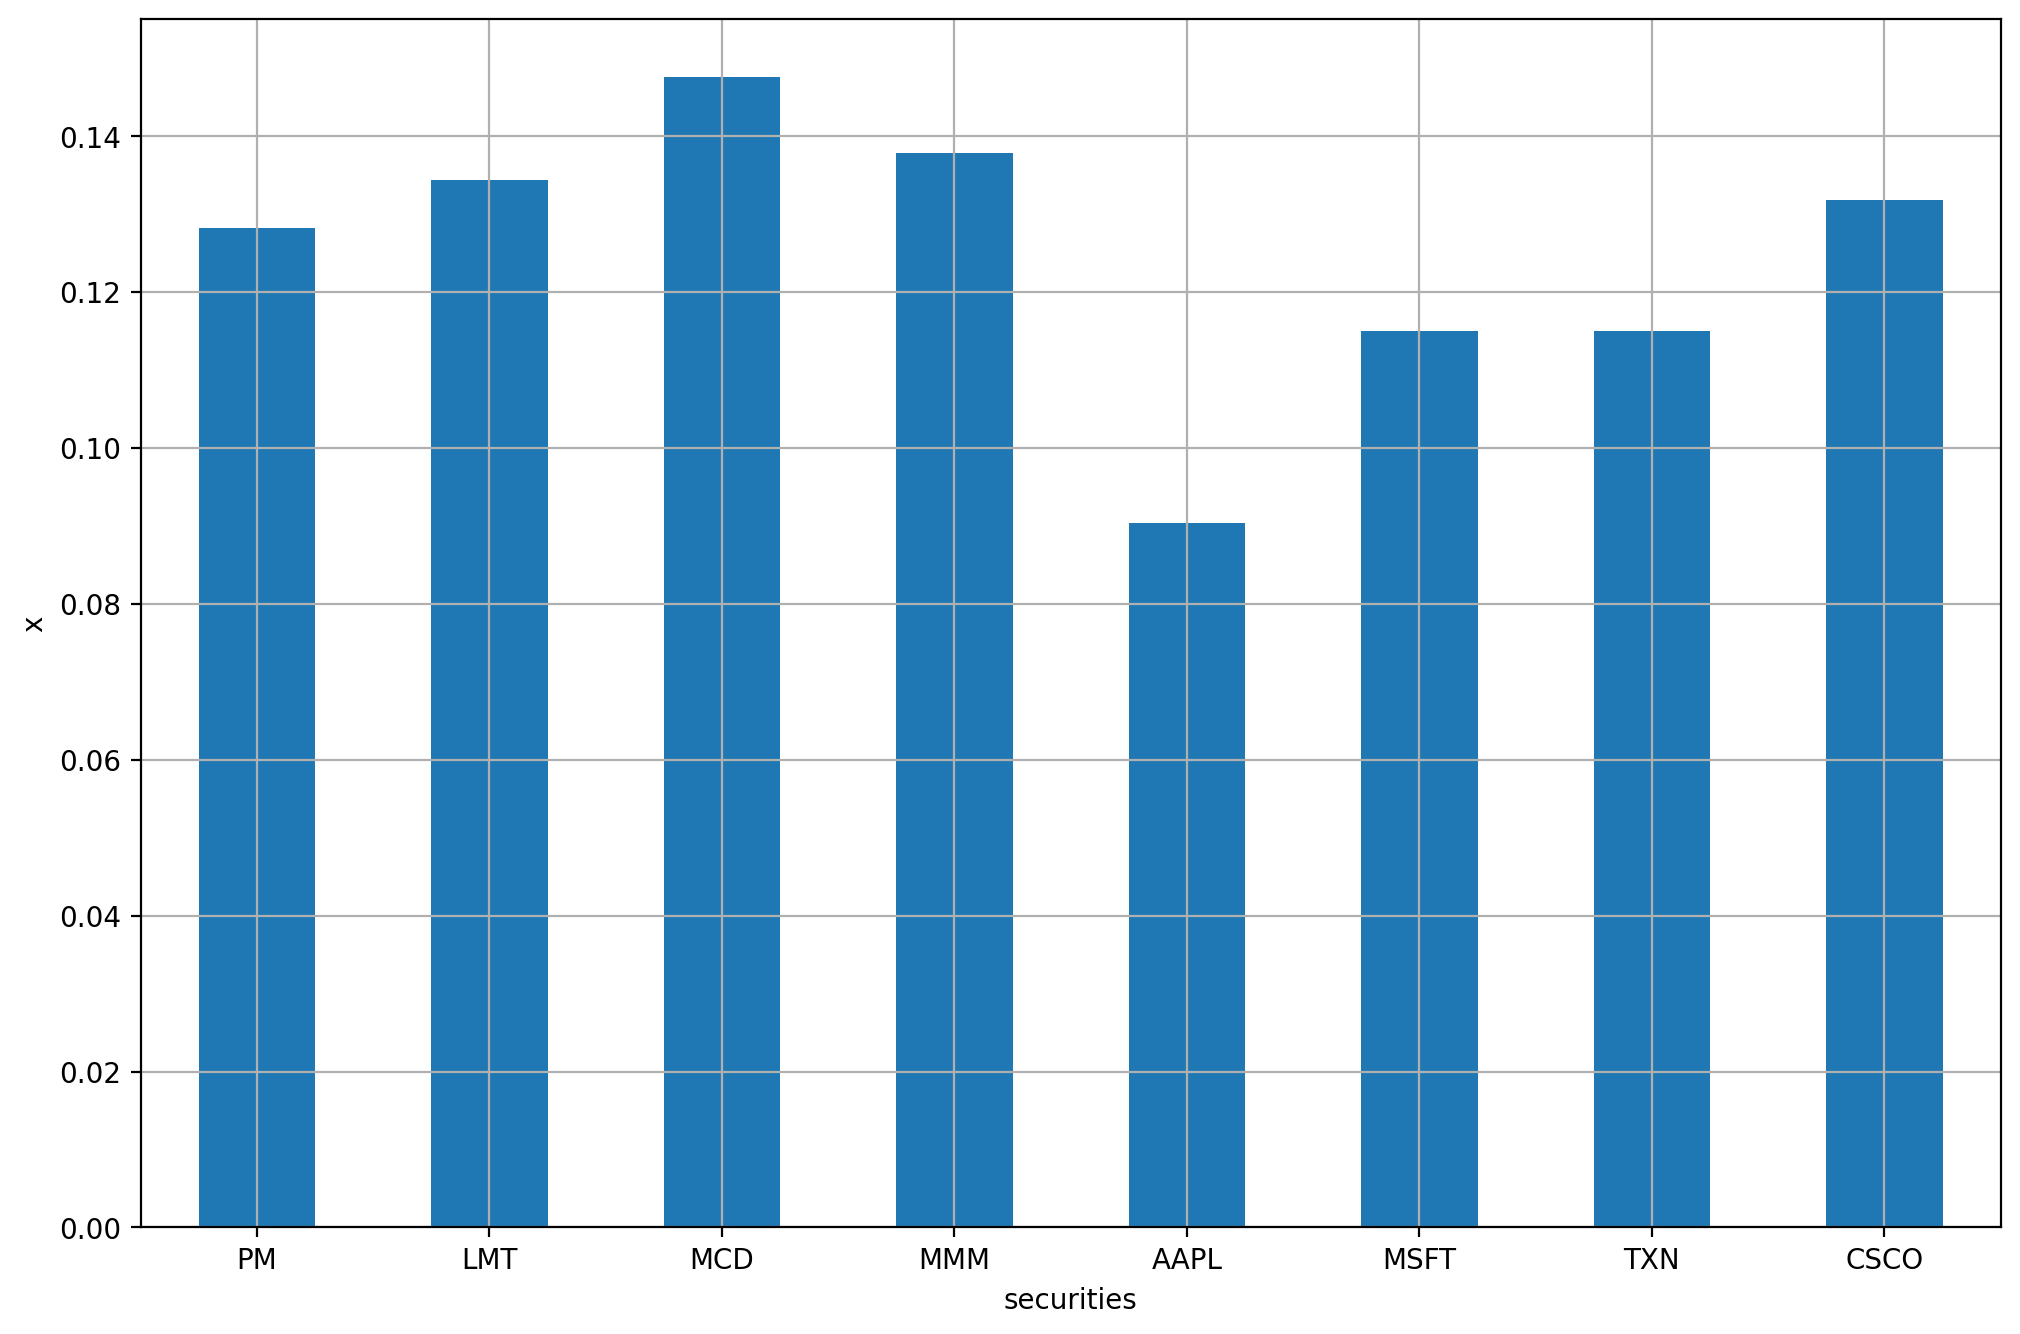

In [11]:
ax = df_result.iloc[0, 4:].T.plot.bar(xlabel="securities", ylabel="x", grid=True, rot=0)

Plot the risk budgets.

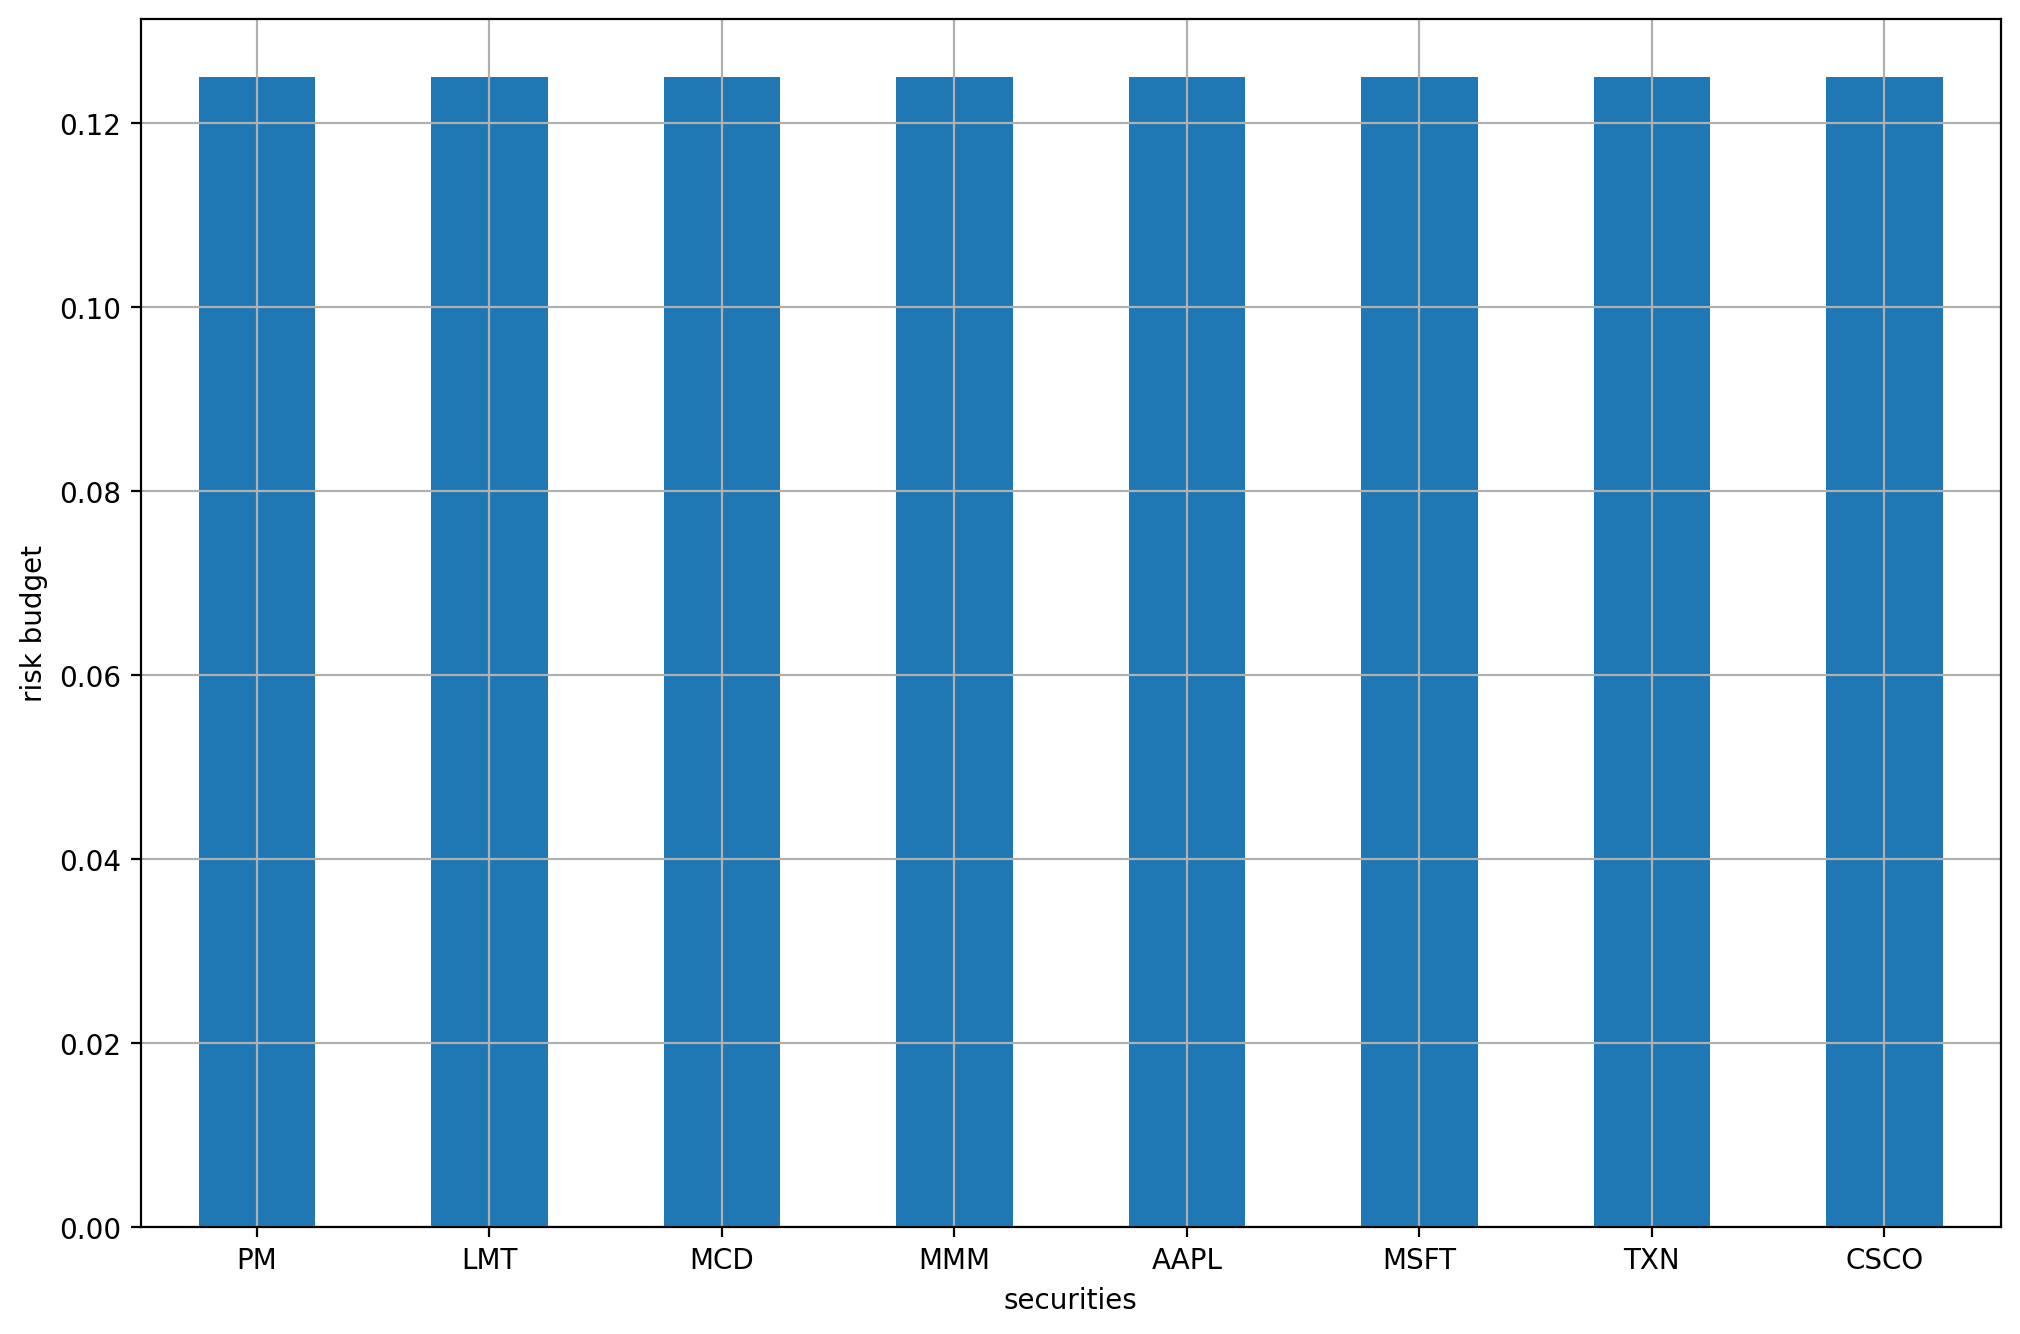

In [12]:
ax = df_result.iloc[1, 4:].T.plot.bar(xlabel="securities", ylabel="risk budget", grid=True, rot=0)